# Semestrální práce -  Detekce transmembránových oblastí proteinových sekvencí
### Metody výpočetní inteligence 2019/2020
### Jaroslav Kurfurst


### Physical properties data

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers.python.layers import initializers
from tqdm.notebook import tqdm

/home/jarda/venvs/mi-mvi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jarda/venvs/mi-mvi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jarda/venvs/mi-mvi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jarda/venvs/mi-mvi/lib/python3.6/site-packages/tensorflow/python/frame

In [2]:
# Selected physical-chemical properties of aminoacids:
# Aminoacid : [LogP, Propensity, VanDerWalls_Volume, Ranking of AA polarities]

AA_prop = {
    'A' : [0.68, 0.599, 67, 9],
    'R' : [1.65, 0.007, 148, 15],
    'N' : [3.82, 0.132, 96, 16],
    'D' : [3.71, 0.021, 91, 19],
    'C' : [2.58, 0.514, 86, 7],
    'Q' : [4.077, 0.078, 114, 17],
    'E' : [3.349, 0.011, 109, 18],
    'G' : [3.200, 0.494, 66, 11],
    'H' : [3.429, 0.135, 167, 10],
    'I' : [1.6, 0.929, 169, 1],
    'L' : [1.389, 0.817, 168, 3],
    'K' : [2.949, 0.000, 171, 20],
    'M' : [1.853, 0.655, 171, 5],
    'F' : [1.575, 1.000, 203, 2],
    'P' : [0.185, 0.230, 129, 13],
    'S' : [3.956, 0.328, 99, 14],
    'T' : [1.233, 0.362, 122, 12],
    'W' : [1.038, 0.791, 240, 6],
    'Y' : [2.711, 0.455, 203, 8],
    'V' : [2.169, 0.775, 142, 4]
}

# Sources:
# http://proteinsandproteomics.org/content/free/tables_1/table08.pdf (VDW Vol., Polarities)
# ChemSpider (LogP)
# Pasquier Hamodrakas 1999 (Propensities)

### Min-Max normalization of input physical properties data

In [3]:
# Min-Max normalization of selected properties: LogP, VanDerWaals radius, Polarity ranking:

# Transform values of dictionary into list, for easy min and max retrieval
logPs = [AA_prop[x][0] for x in AA_prop.keys()]
vdws = [AA_prop[x][2] for x in AA_prop.keys()]
pols = [AA_prop[x][3] for x in AA_prop.keys()]

# Substract these minimal values from all values
for i in AA_prop.keys():
    AA_prop[i][0] = AA_prop[i][0] - min(logPs)
    AA_prop[i][2] = AA_prop[i][2] - min(vdws)
    AA_prop[i][3] = AA_prop[i][3] - min(pols)

# Transform values of dictionary into list, for easy min and max retrieval
logPs = [AA_prop[x][0] for x in AA_prop.keys()]
vdws = [AA_prop[x][2] for x in AA_prop.keys()]
pols = [AA_prop[x][3] for x in AA_prop.keys()]


# Divide all values by found Maximal values
for i in AA_prop.keys():
    AA_prop[i][0] = AA_prop[i][0] / max(logPs)
    AA_prop[i][2] = AA_prop[i][2] / max(vdws)
    AA_prop[i][3] = AA_prop[i][3] / max(pols)


AA_prop

{'A': [0.12718396711202468, 0.599, 0.005747126436781609, 0.42105263157894735],
 'R': [0.3764131551901336, 0.007, 0.47126436781609193, 0.7368421052631579],
 'N': [0.933967112024666, 0.132, 0.1724137931034483, 0.7894736842105263],
 'D': [0.9057040082219938, 0.021, 0.14367816091954022, 0.9473684210526315],
 'C': [0.6153648509763617, 0.514, 0.11494252873563218, 0.3157894736842105],
 'Q': [1.0, 0.078, 0.27586206896551724, 0.8421052631578947],
 'E': [0.8129496402877698, 0.011, 0.2471264367816092, 0.8947368421052632],
 'G': [0.7746659815005139, 0.494, 0.0, 0.5263157894736842],
 'H': [0.8335046248715313, 0.135, 0.5804597701149425, 0.47368421052631576],
 'I': [0.36356628982528266, 0.929, 0.5919540229885057, 0.0],
 'L': [0.30935251798561153, 0.817, 0.5862068965517241, 0.10526315789473684],
 'K': [0.710174717368962, 0.0, 0.603448275862069, 1.0],
 'M': [0.42857142857142855, 0.655, 0.603448275862069, 0.21052631578947367],
 'F': [0.35714285714285715, 1.0, 0.7873563218390804, 0.05263157894736842],
 '

### Masking, Encoding functions

In [4]:
# In:  sequence of aminoacids encoded in single letter code
# Out: sequence of vectors, each aminoacid gets represented by a vector of its PhysChem properties

def EncodeAA(seq):
    encoded = []
    for s in seq:
        encoded.append(AA_prop[s])
    return encoded

In [5]:
# In:  seq = Aminoacid sequence
# In:  tmh = List of tuples, each tuple describes range of one transmembrane helix
# Out: sequence of 0's and 1's. 
#          0 == Non-transmembrane aminoacid
#          1 == Aminoacid is a part of a transmembrane helix

def MaskTM(seq, tmh):
    masked = ''
    
    pos = 0
    
    for m in tmh:
        
        if m[0] == '<1':
            m = (0, m[1])
            
        if '>' in m[1]:
            m = (m[0], m[1].strip('>'))
        
        masked  = masked + (int(m[0]) - pos - 1)*'0'
        pos += (int(m[0]) - pos)
        
        masked = masked + (int(m[1]) - int(m[0]) + 1)*'1'
        pos += (int(m[1]) - int(m[0]))
    
    masked = masked + (len(seq) - pos)*'0'
        
    return masked    

### Uniprot data loading, data masking and encoding

In [6]:
# Here, downloaded transmembrane protein data from uniprot gets loaded, parsed, filtered, adjusted for 
# easier manipulation, proteins get encoded using function EncodeAA and masked using function MaskTM.

uniData = [] 
masked = []
encoded = []
skip = 0

AAs = ('A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V')

with open("/home/jarda/Documents/skola/mvi/semestralka/testuniprot1000.tsv")as f:
    for line in f:
        line = line.strip().split('\t')
        skip = 0

        # filter unnatural or unknown aminoacids
        for aa in line[3].strip():
            if aa not in AAs:
                skip = 1
        
        
        # filter mistakes in TM range field
        if ('?' in line[4]):
            skip == 1
        if ('>' in line[4]):
            skip == 1
        if ('<' in line[4]):
            skip == 1
            
            
        if skip == 1:
            continue
            
        else:
            uniData.append(line)
    
print("Number of loaded proteins (After filtering): ", len(uniData))

for i in range(0, len(uniData)):
    
    i_tmhs = []
    tm_annot = uniData[i][4].split()
    for j in range(0, len(tm_annot)):
        if tm_annot[j] == "TRANSMEM":
            i_tmhs.append((tm_annot[j + 1], tm_annot[j + 2]))
            
    masked.append(MaskTM(uniData[i][3], i_tmhs))
    encoded.append(EncodeAA(uniData[i][3]))
    
# forget about uniData
uniData = []
    
c_data = []

if (len(masked) == len(encoded)):
    for n in range(0, len(masked)):
        for i, j in zip(encoded[n], masked[n]):
            if j == '0':
                c_data.append((i, [1, 0]))
            else:
                c_data.append((i, [0, 1]))

Number of loaded proteins (After filtering):  993


In [7]:
# c_data:
# [([AA encoding], [hot-1 TRANSMEMBRANE / NON-TRANSMEMBRANE])]
# AA encoding = vector of 4 numbers describing various physical-chemical properties of each aminoacid (0-1)

c_data[0:5]

[([0.42857142857142855, 0.655, 0.603448275862069, 0.21052631578947367],
  [1, 0]),
 ([0.3764131551901336, 0.007, 0.47126436781609193, 0.7368421052631579],
  [1, 0]),
 ([0.5097636176772867, 0.775, 0.4367816091954023, 0.15789473684210525],
  [1, 0]),
 ([0.8335046248715313, 0.135, 0.5804597701149425, 0.47368421052631576],
  [1, 0]),
 ([0.6490236382322713, 0.455, 0.7873563218390804, 0.3684210526315789], [1, 0])]

In [8]:
# Here, data stored in variable c_data gets transformed in following manner:
# vectors of PhysChem properties get concatenated in chunks of 25 aminoacids
# which is the window size, I found to be most efective.

# Then a hot-1 vector is added, describing the TM / non-TM character of currently
# studied aminoacid, This is the aminoacid in the middle of current window.

# Everything gets bundled-up into a numpy data structure which is needed for tensorflow.
# Data also gets shuffled to reduce bias.

window_size = 25
step = 1
s = []
slices_x = []
slices_y = []

# Calculation of training/testing ratio
dataset_size = len(c_data)
border = int((dataset_size/100)*75)

tr_size_counter = 0

for pos in range(0, len(c_data) - (window_size - 1), step):
    s = c_data[pos : pos + window_size]
    s_concat = []
    for j in s:
        s_concat.extend(j[0])
        
    tr_size_counter += 1
        
    slices_x.append(np.asarray(s_concat))
    slices_y.append(s[window_size//2][1])
    
slices_x = np.asarray(slices_x)
slices_y = np.asarray(slices_y)


# These slices get shuffled to reduce any bias
perm = np.random.permutation(slices_x.shape[0])
slices_shuffled_x = slices_x[perm]
slices_shuffled_y = slices_y[perm]
training_slices_x, testing_slices_x = slices_shuffled_x[:border], slices_shuffled_x[border:]
training_slices_y, testing_slices_y = slices_shuffled_y[:border], slices_shuffled_y[border:]
    
    
print('------------------------------')
print("training dataset size (windows): ", len(training_slices_x))
print("testing dataset size (windows): ", len(testing_slices_x))
print('------------------------------')


------------------------------
training dataset size (windows):  292125
testing dataset size (windows):  97351
------------------------------


### Detection

In [9]:
# parameters
learning_rate = 0.00001
number_of_iterations = 100
number_of_epochs = 2

# model
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 100])
y = tf.placeholder(tf.float32, [None, 2])

layer1 = tf.layers.dense(x, 100, activation=tf.nn.relu)
layer2 = tf.layers.dense(layer1, 50, activation=tf.nn.relu)
logits = tf.layers.dense(layer2, 2)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
# train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init_op = tf.global_variables_initializer()

batch_size = 10
number_of_batches = len(training_slices_x) // batch_size
data_index = 0

# for 
tr_accuracies = []
tr_losses = []
ts_accuracies = []
ts_losses = []

with tf.Session() as sess:
  
    sess.run(init_op)
    
    # training
    for epoch in range(number_of_epochs):
        for batch_number in tqdm(list(range(number_of_batches))):
            data_index = batch_number*batch_size
            batch_xs = training_slices_x[data_index : data_index + batch_size]
            batch_ys = training_slices_y[data_index : data_index + batch_size]

#             data_index += batch_size

            sess.run(train_step, feed_dict = {
                x: batch_xs,
                y: batch_ys
            })
    
            if batch_number % 100 == 0:
                tr_acc, tr_loss = sess.run([accuracy, cross_entropy], feed_dict = {
                    x: batch_xs,
                    y: batch_ys
                })
                tr_accuracies.append(tr_acc)
                tr_losses.append(tr_loss)

                ts_acc, ts_loss = sess.run([accuracy, cross_entropy], feed_dict = {
                    x: testing_slices_x,
                    y: testing_slices_y
                })
                ts_accuracies.append(ts_acc)
                ts_losses.append(ts_loss)

        # evaluation
        accuracy_value = sess.run(accuracy, feed_dict = {
            x: testing_slices_x,
            y: testing_slices_y
        })

print("\nTrained for %d epochs" % number_of_epochs)
print("Accuracy: %.2f%%" % (accuracy_value * 100))
print('=====================================')     

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.





Trained for 2 epochs
Accuracy: 88.23%


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

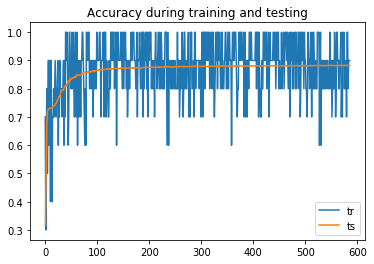

In [11]:
plt.plot(tr_accuracies, label='tr')
plt.plot(ts_accuracies, label='ts')
plt.title("Accuracy during training and testing")
plt.legend()


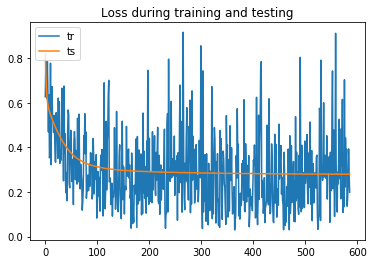

In [12]:
plt.plot(tr_losses, label='tr')
plt.plot(ts_losses, label='ts')
plt.title("Loss during training and testing")
plt.legend()